# Flame Speed with Convergence Analysis

In this example we simulate a freely-propagating, adiabatic, 1-D flame and
* Calculate its laminar burning velocity
* Estimate the uncertainty in the laminar burning velocity calculation, due to grid size.

The figure below illustrates the setup, in a flame-fixed co-ordinate system. The reactants enter with density $\rho_{u}$, temperature $T_{u}$ and speed $S_{u}$. The products exit the flame at speed $S_{b}$, density $\rho_{b}$ and temperature $T_{b}$.

<img src="images/flameSpeed.png" alt="Freely Propagating Flame" style="width: 300px;"/>

### Import Modules

In [1]:
from __future__ import print_function
from __future__ import division

import cantera as ct
import numpy as np

import scipy
import scipy.optimize

%matplotlib inline
from matplotlib import pyplot as plt

print("Running Cantera Version: " + str(ct.__version__))

Running Cantera Version: 2.4.0


### Define the reactant conditions, gas mixture and kinetic mechanism associated with the gas

In [17]:
#Inlet Temperature in Kelvin and Inlet Pressure in Pascals
#In this case we are setting the inlet T and P to room temperature conditions
To = 300
Po = 101325

#Define the gas-mixutre and kinetics
#In this case, we are choosing a GRI3.0 gas
gas = ct.Solution('gri30.cti')

# Create a stoichiometric CH4/Air premixed mixture 
gas.set_equivalence_ratio(1.0, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = To, Po

### Define flame simulation conditions

In [18]:
# Domain width in metres
width = 0.014

# Create the flame object
flame = ct.FreeFlame(gas, width=width)

# Define tolerances for the solver
flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)

# Define logging level
loglevel = 1

In [19]:
def extrapolate_uncertainty(grids, speeds, plot=True):
    """
    Given a list of grid sizes and a corresponding list of flame speeds,
    extrapolate and estimate the uncertainty in the final flame speed.
    Also makes a plot.
    """
    grids = list(grids)
    speeds = list(speeds)
    def speed_from_grid_size(grid_size, true_speed, error):
        """
        Given a grid size (or an array or list of grid sizes)
        return a prediction (or array of predictions)
        of the computed flame speed, based on 
        the parameters `true_speed` and `error`        
        """
        return true_speed +  error * np.array(grid_size)**-1.


    popt, pcov = scipy.optimize.curve_fit(speed_from_grid_size, grids[-4:], speeds[-4:])

    perr = np.sqrt(np.diag(pcov))
    true_speed_estimate  = popt[0]
    percent_error_in_true_speed = 100.*perr[0] / popt[0]
    print("Fitted true_speed is {:.4f} ± {:.4f} cm/s ({:.1f}%)".format(
        popt[0]*100,
        perr[0]*100,
        percent_error_in_true_speed
        ))
    #print "convergerce rate wrt grid size is {:.1f} ± {:.1f}".format(popt[2], perr[2])
    estimated_percent_error = 100. * (speed_from_grid_size(grids[-1], *popt) - true_speed_estimate) / true_speed_estimate
    print("Estimated error in final calculation {:.1f}%".format(estimated_percent_error))

    total_percent_error_estimate = abs(percent_error_in_true_speed) + abs(estimated_percent_error)
    print("Estimated total error {:.1f}%".format(total_percent_error_estimate))
    
    if not plot:
        return true_speed_estimate, total_percent_error_estimate

    plt.semilogx(grids,speeds,'o-')
    plt.ylim(min(speeds[-5:]+[true_speed_estimate])*.95, max(speeds[-5:]+[true_speed_estimate])*1.05)
    plt.plot(grids[-4:], speeds[-4:], 'or')
    extrapolated_grids = grids + [grids[-1] * i for i in range(2,8)]
    plt.plot(extrapolated_grids,speed_from_grid_size(extrapolated_grids,*popt),':r')
    plt.xlim(*plt.xlim())
    plt.hlines(true_speed_estimate, *plt.xlim(), colors=u'r', linestyles=u'dashed')

    plt.hlines(true_speed_estimate+perr[0], *plt.xlim(), colors=u'r', linestyles=u'dashed', alpha=0.3)
    plt.hlines(true_speed_estimate-perr[0], *plt.xlim(), colors=u'r', linestyles=u'dashed', alpha=0.3)
    plt.fill_between(plt.xlim(), true_speed_estimate-perr[0],true_speed_estimate+perr[0], facecolor='red', alpha=0.1 )

    #plt.text(grids[-1],speeds[-1],"{:.1f}%".format(estimated_percent_error))

    above = popt[1]/abs(popt[1]) # will be +1 if approach from above or -1 if approach from below
    
    plt.annotate("",
                 xy=(grids[-1], true_speed_estimate),
                 xycoords='data',
                 xytext=(grids[-1], speed_from_grid_size(grids[-1], *popt)),
                 textcoords='data',
                 arrowprops=dict(arrowstyle='|-|',
                                connectionstyle='arc3',
                                color='black', shrinkA=0, shrinkB=0),
                )
        
    plt.annotate("{:.1f}%".format(abs(estimated_percent_error)),
                 xy=(grids[-1], speed_from_grid_size(grids[-1], *popt)),
                 xycoords='data',
                 xytext=(10,20*above),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->',
                                connectionstyle='arc3')
                )
    
    plt.annotate("",
                 xy=(grids[-1]*4, true_speed_estimate-(above*perr[0])),
                 xycoords='data',
                 xytext=(grids[-1]*4, true_speed_estimate),
                 textcoords='data',
                 arrowprops=dict(arrowstyle='|-|',
                                connectionstyle='arc3',
                                color='black', shrinkA=0, shrinkB=0),
                )
    plt.annotate("{:.1f}%".format(abs(percent_error_in_true_speed)),
                 xy=(grids[-1]*4, true_speed_estimate-(above*perr[0])),
                 xycoords='data',
                 xytext=(10,-20*above),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->',
                                connectionstyle='arc3')
                )

    plt.ylabel("Flame speed (m/s)")
    plt.xlabel("Grid size")
    plt.show()
    
    return true_speed_estimate, total_percent_error_estimate

In [36]:
def make_callback(flame):
    speeds = []
    grids = []

    def callback(_):
        speed = flame.u[0]
        grid = len(flame.grid)
        speeds.append(speed)
        grids.append(grid)
        print("Iteration {}".format(len(grids)))
        print("Current flame speed is is {:.4f} cm/s".format(speed*100.))
        if len(grids) < 5:
            return 1.0 # 
        try:
            extrapolate_uncertainty(grids, speeds)
        except Exception as e:
            print("Couldn't estimate uncertainty. " + str(e))
            return 1.0 # continue anyway

        return 1.0
    return callback, speeds, grids


In [21]:
refine_criteria = {'ratio':2, 'slope': 0.05, 'curve': 0.05}
flame.set_refine_criteria(**refine_criteria)
flame.set_max_grid_points(flame.domains[flame.domain_index('flame')], 1e4)

callback, speeds, grids = make_callback(flame)
flame.set_steady_callback(callback)

# Define logging level
loglevel = 1

### Solve


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      5.453
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0003649      4.427
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.624e-05      6.027
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     3.468e-05      5.679
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.001333      4.123
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accomodate flame thickness. New width: 0.028 m
##############################################################################
Refining grid in flame.
    New points inserted after grid

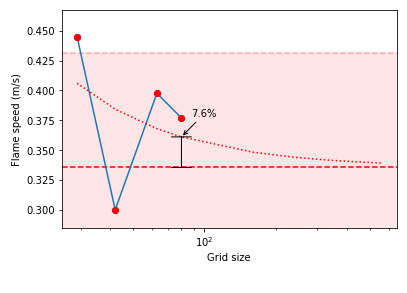


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 3 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 76 
    to resolve C C2H C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO CO2 H H2 H2O H2O2 HCCO HCCOH HCN HCNO HCO HNCO HO2 N N2 N2O NCO NO NO2 O O2 OH T point 3 u 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [100] point grid(s).
Iteration 6
Current flame speed is is 37.3780 cm/s
Fitted true_speed is 44.9786 ± 5.0134 cm/s (11.1%)
Estimated error in final calculation -12.5%
Estimated total error 23.7%


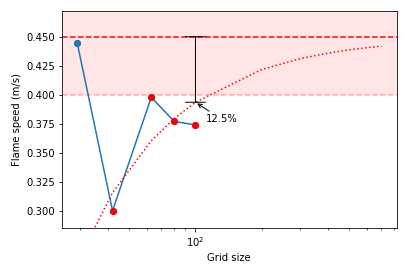


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 2 20 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 57 
    to resolve C C2H C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO CO2 H H2 H2O H2O2 HCCO HCCOH HCN HCNO HCO HNCO HO2 N N2 NCO NO NO2 O O2 OH T point 2 point 20 point 57 u 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [126] point grid(s).
Iteration 7
Current flame speed is is 37.4030 cm/s
Fitted true_speed is 34.6078 ± 1.2912 cm/s (3.7%)
Estimated error in final calculation 6.8%
Estimated total error 10.6%


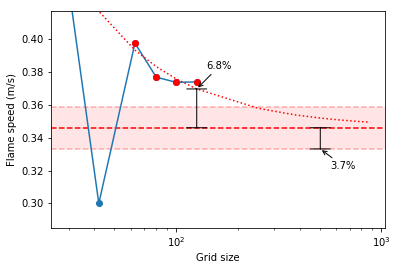


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 75 123 
    to resolve C C2H C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO CO2 H H2 H2O H2O2 HCCO HCCOH HCN HCO HNCO HO2 N2 NO NO2 O O2 OH T point 75 u 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [163] point grid(s).
Iteration 8
Current flame speed is is 37.5252 cm/s
Fitted true_speed is 37.2611 ± 0.3060 cm/s (0.8%)
Estimated error in final calculation 0.4%
Estimated total error 1.3%


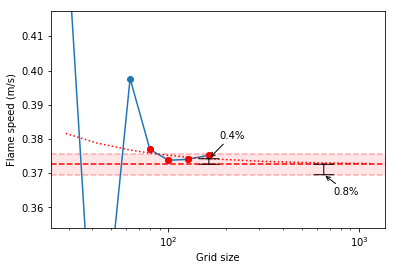


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 32 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 161 
    to resolve C C2H2 C2H3 C2H4 C2H5 C2H6 C3H7 C3H8 CH CH2 CH2(S) CH2CHO CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3OH CH4 CO H H2 H2O H2O2 HCCO HCCOH HCN HCO HO2 N2 NO2 O O2 OH T point 161 point 32 u 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [217] point grid(s).
Iteration 9
Current flame speed is is 37.6909 cm/s
Fitted true_speed is 37.9122 ± 0.1134 cm/s (0.3%)
Estimated error in final calculation -0.7%
Estimated 

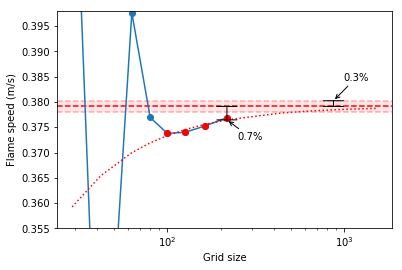


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 31 62 63 64 65 66 67 68 69 70 71 72 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 
    to resolve C2H2 C2H3 C2H4 C2H5 C2H6 C3H8 CH CH2 CH2(S) CH2CO CH2OH CH3 CH3CHO CH3O HCCO HCO point 31 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [274] point grid(s).
Iteration 10
Current flame speed is is 37.8516 cm/s
Fitted true_speed is 38.1900 ± 0.0799 cm/s (0.2%)
Estimated error in final calculation -1.0%
Estimated total error 1.2%


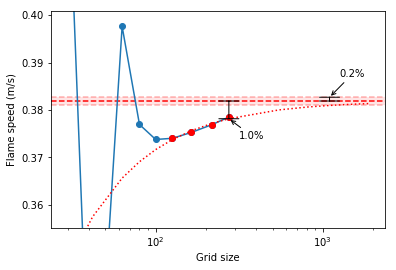


..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 98 
    to resolve point 98 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [275] point grid(s).
Iteration 11
Current flame speed is is 37.8501 cm/s
Fitted true_speed is 38.3220 ± 0.0470 cm/s (0.1%)
Estimated error in final calculation -1.2%
Estimated total error 1.4%


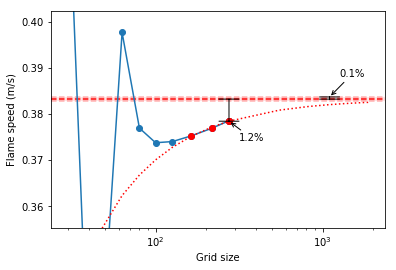


..............................................................................
no new points needed in flame
Flame Speed is: 37.85 cm/s


In [22]:
flame.solve(loglevel=loglevel, auto=True)

Su0 = flame.u[0]
print("Flame Speed is: {:.2f} cm/s".format(Su0*100))


Fitted true_speed is 38.3220 ± 0.0470 cm/s (0.1%)
Estimated error in final calculation -1.2%
Estimated total error 1.4%


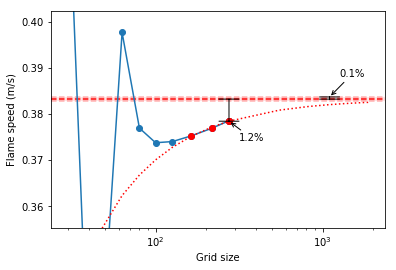

In [23]:
true_speed_estimate, total_percent_error_estimate =  extrapolate_uncertainty(grids, speeds)

In [24]:
grids

[29, 29, 42, 63, 80, 100, 126, 163, 217, 274, 275]

Fitted true_speed is 38.3220 ± 0.0470 cm/s (0.1%)
Estimated error in final calculation -1.2%
Estimated total error 1.4%


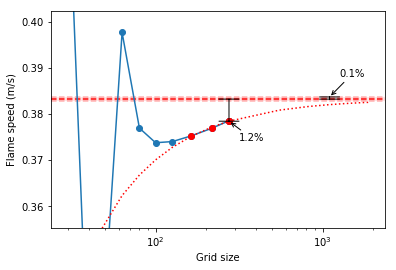

[29, 29, 42]
Fitted true_speed is -2.3173 ± 0.0008 cm/s (-0.0%)
Estimated error in final calculation -1394.5%
Estimated total error 1394.5%
Actual total error (with hindsight) 106.0%

[29, 29, 42, 63]
Fitted true_speed is 28.4308 ± 12.6026 cm/s (44.3%)
Estimated error in final calculation 23.1%
Estimated total error 67.5%
Actual total error (with hindsight) 25.8%

[29, 29, 42, 63, 80]
Fitted true_speed is 33.5575 ± 9.5869 cm/s (28.6%)
Estimated error in final calculation 7.6%
Estimated total error 36.2%
Actual total error (with hindsight) 12.4%

[29, 29, 42, 63, 80, 100]
Fitted true_speed is 44.9786 ± 5.0134 cm/s (11.1%)
Estimated error in final calculation -12.5%
Estimated total error 23.7%
Actual total error (with hindsight) 17.4%

[29, 29, 42, 63, 80, 100, 126]
Fitted true_speed is 34.6078 ± 1.2912 cm/s (3.7%)
Estimated error in final calculation 6.8%
Estimated total error 10.6%
Actual total error (with hindsight) 9.7%

[29, 29, 42, 63, 80, 100, 126, 163]
Fitted true_speed is 37.261

In [27]:
final_true_speed_estimate, total_percent_error_estimate =  extrapolate_uncertainty(grids, speeds)

true_speed_estimates = [None for i in speeds]
total_percent_error_estimates = [None for i in speeds]
actual_total_percent_errors = [None for i in speeds]
for i in range(3,len(grids)):
    print(grids[:i])
    true_speed_estimate, total_percent_error_estimate = extrapolate_uncertainty(grids[:i], speeds[:i], plot=False)
    actual_total_percent_error = 100. * abs(true_speed_estimate - final_true_speed_estimate) / final_true_speed_estimate
    print("Actual total error (with hindsight) {:.1f}%".format(actual_total_percent_error))
    
    true_speed_estimates[i] = true_speed_estimate
    total_percent_error_estimates[i] = total_percent_error_estimate
    actual_total_percent_errors[i] = actual_total_percent_error
    print()



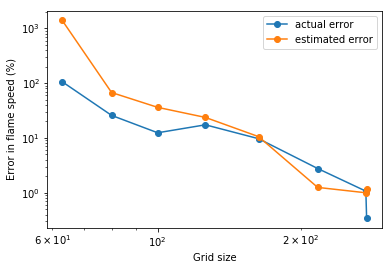

In [30]:

plt.loglog(grids, actual_total_percent_errors,'o-', label='actual error')
plt.loglog(grids, total_percent_error_estimates,'o-', label='estimated error')
plt.ylabel("Error in flame speed (%)")
plt.xlabel("Grid size")
plt.legend()
plt.show()

In [35]:
import pandas as pd
pd.DataFrame(data={'actual error':actual_total_percent_errors,
                   'estimated error':total_percent_error_estimates}, index=grids)

,actual error,estimated error
29,NaN,NaN
29,NaN,NaN
42,NaN,NaN
63,106.047012,1394.533260
80,25.810793,67.454508
100,12.432949,36.180548
126,17.369997,23.688816
163,9.692265,10.568768
217,2.768619,1.251802
274,1.069477,0.999250


In [ ]:
raise NotImplementedError("Stop here!")

### Plot figures

Check and see if all has gone well. Plot temperature and species fractions to see

In [ ]:
# Import plotting modules and define plotting preference
import matplotlib.pylab as plt
%matplotlib notebook

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (8,6)

# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')

plt.rcParams['figure.autolayout'] = True

#### Temperature Plot

In [ ]:
plt.figure()

plt.plot(flame.grid*100, flame.T, '-o')
plt.xlabel('Distance (cm)')
plt.ylabel('Temperature (K)');

#### Major species' plot

In [ ]:
"""
# To plot species, we first have to identify the index of the species in the array
# For this, cut & paste the following lines and run in a new cell to get the index
for i, specie in enumerate(gas.species()):
    print(str(i) + '. ' + str(specie))
"""

# Extract concentration data
X_CH4 = flame.X[13]
X_CO2 = flame.X[15]
X_H2O = flame.X[5]

plt.figure()

plt.plot(flame.grid*100, X_CH4, '-o', label=r'$CH_{4}$')
plt.plot(flame.grid*100, X_CO2, '-s', label=r'$CO_{2}$')
plt.plot(flame.grid*100, X_H2O, '-<', label=r'$H_{2}O$')

plt.legend(loc=2)
plt.xlabel('Distance (cm)')
plt.ylabel('MoleFractions');